# (Wang, 2000) Working memory model

Implementation of the paper:

- Compte, Albert, et al. "Synaptic mechanisms and network dynamics underlying spatial working memory in a cortical network model." Cerebral cortex 10.9 (2000): 910-923.

In [1]:
import brainpy as bp
import numpy as np
import bpmodels
import matplotlib.pyplot as plt
import math
from scipy.special import erf

In [2]:
def rotate_distance(x, y):
    dist = np.abs(x - y)
    return min(dist, 360 - dist)

In [3]:
# set params
## set global params
dt=0.1
bp.profile.set(jit=True,
               device='cpu',
               dt=dt,
               numerical_method='exponential')

base_N_E = 2048
base_N_I = 512
net_scale = 8
N_E = base_N_E//net_scale
N_I = base_N_I//net_scale
time_scale = 10.
pre_period = 1000. / time_scale
cue_period = 250.
delay_period = 8750. / time_scale
resp_period = 250.
post_period = 1000. / time_scale
dist_period = 250.
total_period = pre_period + cue_period + delay_period + resp_period + post_period

In [4]:
## set neuron params
### E-neurons/pyramidal cells
C_E = 0.5          #nF
g_E = 25. * 1e-3   #uS
R_E = 1/g_E        #MOhm
tau_E = R_E * C_E  #ms
V_rest_E = -70.    #mV
V_reset_E = -60.   #mV
V_th_E = -50.      #mV
t_refractory_E = 2.#ms
### I-neurons/interneurons
C_I = 0.2          #nF
g_I = 20. * 1e-3   #uS
R_I = 1/g_I        #MOhm
tau_I = R_I * C_I  #ms
V_rest_I = -70.    #mV
V_reset_I = -60.   #mV
V_th_I = -50.      #mV
t_refractory_I = 1.#ms

def get_LIF(V_rest=0., V_reset=0., V_th=0., R=0., tau=0., t_refractory=0.):
    ST = bp.types.NeuState('V', 'input', 'spike', 'refractory', t_last_spike = -1e7)
    
    @bp.integrate
    def int_V(V, t, I_ext):  # integrate u(t)
        return (- (V - V_rest) + R * I_ext) / tau

    def update(ST, _t):
        # update variables
        ST['spike'] = 0
        if _t - ST['t_last_spike'] <= t_refractory:
            ST['refractory'] = 1.
        else:
            ST['refractory'] = 0.
            V = int_V(ST['V'], _t, ST['input'])
            if V >= V_th:
                V = V_reset
                ST['spike'] = 1
                ST['t_last_spike'] = _t
            ST['V'] = V
            
    def reset(ST):
        ST['input'] = 0.  # reset input here or it will be brought to next step

    return bp.NeuType(name='LIF_neuron',
                      ST=ST,
                      steps=(update, reset),
                      mode='scalar')

In [5]:
## set input params
poission_frequency = 1800
g_max_input2E = 3.1 * 1e-3      #uS  #AMPA
g_max_input2I = 2.38 * 1e-3     #uS  #AMPA

In [6]:
## set synapse params
### AMPA
tau_AMPA = 2.  #ms
E_AMPA = 0.    #mV
### GABAa
tau_GABAa = 10. #ms
E_GABAa = -70.  #mV
### NMDA
tau_decay_NMDA = 100. #ms
tau_rise_NMDA = 2.    #ms
cc_Mg_NMDA = 1.       #mM
alpha_NMDA = 0.062    #/
beta_NMDA = 3.57      #/
a_NMDA = 0.5          #kHz
E_NMDA = 0.           #mV
g_max_E2E = 0.381 * 1e-3 * net_scale   #uS
g_max_E2I = 0.292 * 1e-3 * net_scale   #uS
g_max_I2E = 1.336 * 1e-3 * net_scale   #uS
g_max_I2I = 1.024 * 1e-3 * net_scale   #uS

def get_NMDA(g_max=0., E=E_NMDA, alpha=alpha_NMDA, beta=beta_NMDA, 
             cc_Mg=cc_Mg_NMDA, a=a_NMDA, 
             tau_decay=tau_decay_NMDA, tau_rise=tau_rise_NMDA, 
             mode = 'vector'):

    ST=bp.types.SynState('s', 'x', 'g')

    requires = dict(
        pre=bp.types.NeuState(['spike']),
        post=bp.types.NeuState(['V', 'input'])
    )

    @bp.integrate
    def int_x(x, t):
        return -x / tau_rise

    @bp.integrate
    def int_s(s, t, x):
        return -s / tau_decay + a * x * (1 - s)
    
    if mode == 'scalar':
        def update(ST, _t, pre):
            x = int_x(ST['x'], _t)
            x += pre['spike']
            s = int_s(ST['s'], _t, x)
            ST['x'] = x
            ST['s'] = s
            ST['g'] = g_max * s

        @bp.delayed
        def output(ST, post):
            I_syn = ST['g'] * (post['V'] - E)
            g_inf = 1 / (1 + cc_Mg / beta * np.exp(-alpha * post['V']))
            post['input'] -= I_syn * g_inf

    elif mode == 'vector':
        requires['pre2syn']=bp.types.ListConn(help='Pre-synaptic neuron index -> synapse index')
        requires['post2syn']=bp.types.ListConn(help='Post-synaptic neuron index -> synapse index')
                
        def update(ST, _t, pre, pre2syn):
            for pre_id in range(len(pre2syn)):
                if pre['spike'][pre_id] > 0.:
                    syn_ids = pre2syn[pre_id]
                    ST['x'][syn_ids] += 1.
            x = int_x(ST['x'], _t)
            s = int_s(ST['s'], _t, x)
            ST['x'] = x
            ST['s'] = s
            ST['g'] = g_max * s

        @bp.delayed
        def output(ST, post, post2syn):
            g = np.zeros(len(post2syn), dtype=np.float_)
            for post_id, syn_ids in enumerate(post2syn):
                g[post_id] = np.sum(ST['g'][syn_ids])    
            I_syn = g * (post['V'] - E)
            g_inf = 1 / (1 + cc_Mg / beta * np.exp(-alpha * post['V']))
            post['input'] -= I_syn * g_inf

    elif mode == 'matrix':
        requires['conn_mat']=bp.types.MatConn()

        def update(ST, _t, pre, conn_mat):
            x = int_x(ST['x'], _t)
            #x += pre['spike'].reshape((-1, 1)) * conn_mat
            for i in range(pre['spike'].shape[0]):
                if pre['spike'][i] > 0.:
                    x[i] += conn_mat[i]
            s = int_s(ST['s'], _t, x)
            ST['x'] = x
            ST['s'] = s
            ST['g'] = g_max * s

        @bp.delayed
        def output(ST, post):
            g = np.sum(ST['g'], axis=0)
            I_syn = g * (post['V'] - E)
            g_inf = 1 / (1 + cc_Mg / beta * np.exp(-alpha * post['V']))
            post['input'] -= I_syn * g_inf

    else:
        raise ValueError("BrainPy does not support mode '%s'." % (mode))

    return bp.SynType(name='NMDA_synapse',
                      ST=ST, requires=requires,
                      steps=(update, output),
                      mode = mode)

In [7]:
## set stimulus params
### cue
cue_angle = 160.
cue_width = 36.
cue_amp = 0.15   #nA(10^-9)
cue_idx = N_E * (cue_angle / 360.)
cue_idx_neg = int(N_E * ((cue_angle-(cue_width/2)) / 360.))
cue_idx_pos = int(N_E * ((cue_angle+(cue_width/2)) / 360.))
# here: may cause bug when idx go pass 360.
### distarctor
dist_angle = 30.
dist_width = 36.
dist_amp = cue_amp  #nA(10^-9)  # distractor stimulation always equal to cue stimulation
dist_idx = N_E * (dist_angle / 360.)
dist_idx_neg = int(N_E * ((dist_angle-(dist_width/2)) / 360.))
dist_idx_pos = int(N_E * ((dist_angle+(dist_width/2)) / 360.))
### response
resp_amp = 0.5  #nA(10^-9)

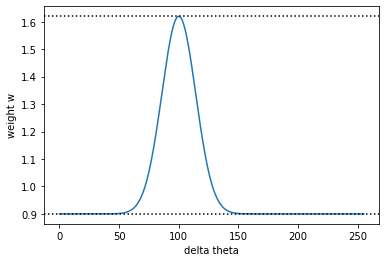

In [8]:
# define weight
## structured weight
prefer_cue_E = np.linspace(0, 360, N_E+1)[:-1]
prefer_cue_I = np.linspace(0, 360, N_I+1)[:-1]
delta_E2E = 20.
J_plus_E2E = 1.62
tmp = math.sqrt(2. * math.pi) * delta_E2E * erf(180. / math.sqrt(2.) / delta_E2E) / 360.
J_neg_E2E = (1. - J_plus_E2E * tmp) / (1. - tmp)
JE2E = []
for i in range(N_E**2):
    JE2E.append(J_neg_E2E + 
                (J_plus_E2E - J_neg_E2E) * 
                np.exp(- 0.5 * rotate_distance(prefer_cue_E[i//N_E], prefer_cue_E[i%N_E])**2/delta_E2E ** 2))
JE2E = np.array(JE2E)

### visualize w-delta_theta plot
plt.plot(range(0, N_E), JE2E.reshape((N_E, N_E))[100])
plt.xlabel("delta theta")
plt.ylabel("weight w")
plt.axhline(y = J_plus_E2E, ls = ":", c = "k", label = "J+")
plt.axhline(y = J_neg_E2E, ls = ":", c = "k", label = "J-")
plt.show()
#print("Check constraints: ", JE2E.reshape((N_E, N_E)).sum(axis=0)[0], "should be equal to ", N_E)
for i in range(N_E):
    JE2E[i*N_E + i] = 0.
JE2E = JE2E.reshape((N_E, N_E))  #for matrix mode

## unstructured weights
JE2I = 1.
JI2E = 1.
JI2I = np.full((N_I ** 2), 1. )
for i in range(N_I):
    JI2I[i*N_I + i] = 0.
JI2I = JI2I.reshape((N_I, N_I))  #for matrix mode

In [9]:
def create_input(cue_angle, cue_width, cue_amp,
                 dist_angle, dist_width, dist_amp,
                 resp_amp
                 ):
    ## build input (with stimulus in cue period and response period)
    input_cue , _  = bp.inputs.constant_current([(0., pre_period), 
                                                (cue_amp, cue_period), 
                                                (0., delay_period), 
                                                (0., resp_period), 
                                                (0., post_period)])
    input_resp, _ = bp.inputs.constant_current([(0., pre_period), 
                                                (0., cue_period), 
                                                (0., delay_period), 
                                                (resp_amp, resp_period), 
                                                (0., post_period)])
    input_dist, _ = bp.inputs.constant_current([(0., pre_period), 
                                                (0., cue_period), 
                                                (0., (delay_period-dist_period)/2), 
                                                (dist_amp, cue_period), 
                                                (0., (delay_period-dist_period)/2), 
                                                (0., resp_period), 
                                                (0., post_period)])
    ext_input = input_resp
    for i in range(1, N_E):
        input_pos = input_resp
        if i >= cue_idx_neg and i <= cue_idx_pos:
            input_pos = input_pos + input_cue
        if i >= dist_idx_neg and i <= dist_idx_pos:
            input_pos = input_pos + input_dist
        ext_input = np.vstack((ext_input, input_pos))
    
    return ext_input.T

In [10]:
def run_simulation(input = None):
    # get neu & syn type
    LIF = get_LIF()
    AMPA = bpmodels.synapses.get_AMPA1(mode = 'matrix')  
    GABAa = bpmodels.synapses.get_GABAa1(mode = 'matrix')
    NMDA = get_NMDA(mode = 'matrix')

    # build neuron groups
    neu_E = bp.NeuGroup(model = LIF, geometry = N_E, monitors = ['V', 'spike', 'input'])
    neu_E.set_schedule(['input', 'update', 'monitor', 'reset'])
    neu_E.pars['V_rest'] = V_rest_E
    neu_E.pars['V_reset'] = V_reset_E
    neu_E.pars['V_th'] = V_th_E
    neu_E.pars['R'] = R_E
    neu_E.pars['tau'] = tau_E
    neu_E.pars['t_refractory'] = t_refractory_E
    neu_I = bp.NeuGroup(model = LIF, geometry = N_I, monitors = ['V'])
    neu_I.set_schedule(['input', 'update', 'monitor', 'reset'])
    neu_I.pars['V_rest'] = V_rest_I
    neu_I.pars['V_reset'] = V_reset_I
    neu_I.pars['V_th'] = V_th_I
    neu_I.pars['R'] = R_I
    neu_I.pars['tau'] = tau_I
    neu_I.pars['t_refractory'] = t_refractory_I

    # build synapse connections                 
    syn_E2E = bp.SynConn(model = NMDA, pre_group = neu_E, post_group = neu_E,
                         conn = bp.connect.All2All())
    syn_E2E.pars['g_max'] = g_max_E2E * JE2E

    syn_E2I = bp.SynConn(model = NMDA, pre_group = neu_E, post_group = neu_I,
                         conn = bp.connect.All2All())
    syn_E2I.pars['g_max'] = g_max_E2I * JE2I

    syn_I2E = bp.SynConn(model = GABAa, pre_group = neu_I, post_group = neu_E,
                         conn = bp.connect.All2All())
    syn_I2E.pars['tau_decay'] = tau_GABAa
    syn_I2E.pars['E'] = E_GABAa
    syn_I2E.pars['g_max'] = g_max_I2E * JI2E

    syn_I2I = bp.SynConn(model = GABAa, pre_group = neu_I, post_group = neu_I,
                         conn = bp.connect.All2All())
    syn_I2I.pars['tau_decay'] = tau_GABAa
    syn_I2I.pars['E'] = E_GABAa
    syn_I2I.pars['g_max'] = g_max_I2I * JI2I

    # set 1800Hz background input
    neu_input = bp.inputs.PoissonInput(geometry = N_E + N_I, freqs = poission_frequency)
    syn_input2E = bp.SynConn(model=AMPA, 
                             pre_group = neu_input[:N_E],
                             post_group = neu_E,
                             conn=bp.connect.One2One(), 
                             delay=0.)
    syn_input2E.pars['tau_decay'] = tau_AMPA
    syn_input2E.pars['E'] = E_AMPA
    syn_input2E.pars['g_max'] = g_max_input2E
    syn_input2I = bp.SynConn(model=AMPA, 
                             pre_group = neu_input[N_E:],
                             post_group = neu_I,
                             conn=bp.connect.One2One(), 
                             delay=0.)
    syn_input2I.pars['tau_decay'] = tau_AMPA
    syn_input2I.pars['E'] = E_AMPA
    syn_input2I.pars['g_max'] = g_max_input2I

    net = bp.Network(neu_input, syn_input2E, syn_input2I, neu_E, neu_I, syn_E2E, syn_E2I, syn_I2E, syn_I2I)

    # run
    net.run(duration=total_period, 
            inputs = (
                      [neu_E, 'ST.input', input, "+"]
                     ),
            report = False)
            
    # visualize
    print("ploting raster plot for simulation...")
    fig, gs = bp.visualize.get_figure(1, 1, 4, 10)

    fig.add_subplot(gs[0, 0])
    bp.visualize.raster_plot(net.ts, neu_E.mon.spike, xlim=(0., total_period), markersize=1)

    plt.show()

ploting raster plot for simulation...


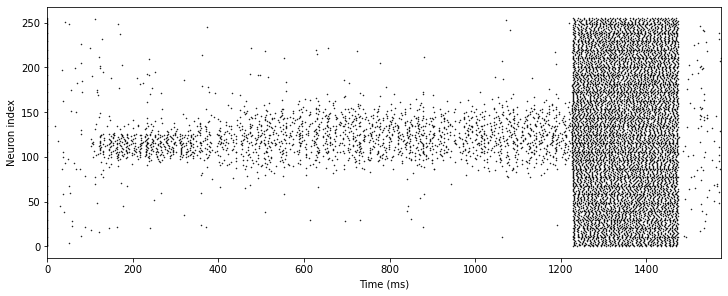

ploting raster plot for simulation...


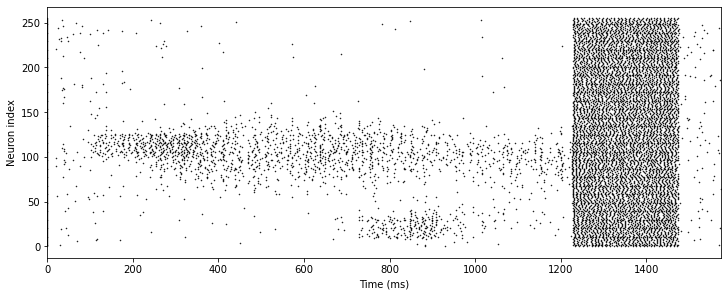

In [11]:
# simulate without distractor
ext_input = create_input(cue_angle = cue_angle, cue_width = cue_width, cue_amp = cue_amp,
                         dist_angle = 0., dist_width = 0., dist_amp = 0.,
                         resp_amp = resp_amp)
run_simulation(input = ext_input)

# simulate with distractor
ext_input = create_input(cue_angle = cue_angle, cue_width = cue_width, cue_amp = cue_amp,
                         dist_angle = dist_angle, dist_width = dist_width, dist_amp = dist_amp,
                         resp_amp = resp_amp)
run_simulation(input = ext_input)